In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Model Seçimi ve Veri Bölme
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Algoritmalar
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Metrikler (Fraud için hayati öneme sahip olanlar)
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    roc_curve
)

# Uyarıları kapatmak için (opsiyonel)
import warnings
warnings.filterwarnings('ignore')

print("Gerekli kütüphaneler başarıyla yüklendi!")

Gerekli kütüphaneler başarıyla yüklendi!


In [6]:
# 1. Temel Yapıyı Kuralım
np.random.seed(42)
n_rows = 2000 # Daha iyi öğrenme için satır sayısını artırdık

data = {
    'Transaction ID': range(10000, 10000 + n_rows),
    'Customer ID': np.random.randint(100, 200, n_rows),
    'Amount (TRY)': np.random.uniform(50, 2000, n_rows),
    'Timestamp': pd.to_datetime('2023-01-01') + pd.to_timedelta(np.random.randint(0, 30*24*60, n_rows), unit='m'),
    'Payment Type': np.random.choice(['Credit Card', 'Debit Card', 'Bank Transfer'], n_rows),
    'Shipping Type': np.random.choice(['Standard', 'Express', 'Pick-up'], n_rows),
    'Card Type (BIN)': np.random.choice(['Visa', 'MasterCard', 'Amex'], n_rows),
    'Shipping City': np.random.choice(['Istanbul', 'Ankara', 'Izmir', 'Bursa', 'Antalya'], n_rows),
    'IS_FRAUD (Target)': 0
}

df = pd.DataFrame(data)

# 2. GERÇEKÇİ "FRAUD" SENARYOLARI EKLEYELİM (Verinin %10'u Fraud olsun)
fraud_indices = np.random.choice(df_new.index, size=int(n_rows * 0.1), replace=False)
df.loc[fraud_indices, 'IS_FRAUD (Target)'] = 1

# Senaryo A: Fraud işlemler genellikle çok yüksek tutarlı olur
df.loc[df_new['IS_FRAUD (Target)'] == 1, 'Amount (TRY)'] *= np.random.uniform(3, 7)

# Senaryo B: Fraud işlemler genellikle gece yarısı olur
# (Saat 02:00 - 05:00 arasına çekiyoruz)
df.loc[df_new['IS_FRAUD (Target)'] == 1, 'Timestamp'] = \
    df.loc[df_new['IS_FRAUD (Target)'] == 1, 'Timestamp'].apply(lambda x: x.replace(hour=np.random.randint(2, 6)))

# 3. Kaydet
df.to_csv('REALISTIC_FRAUD_DATA.csv', index=False)
print("✅ Gerçekçi veri seti oluşturuldu: 'REALISTIC_FRAUD_DATA.csv'")

✅ Gerçekçi veri seti oluşturuldu: 'REALISTIC_FRAUD_DATA.csv'


✅ Yeni özellikler (Frekans, Sapma, Saat) başarıyla eklendi.


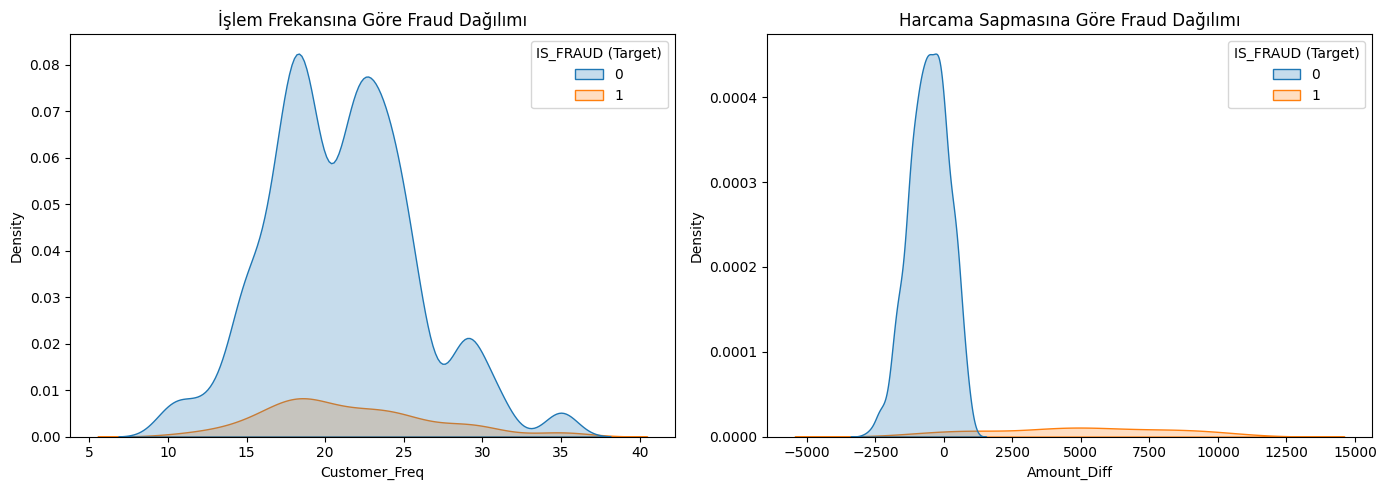

In [7]:
# 1. FREKANS VE HARCAMA ÖZELLİKLERİ (Sizin Kodunuz)
df['Customer_Freq'] = df.groupby('Customer ID')['Transaction ID'].transform('count')
df['Customer_Avg_Amount'] = df.groupby('Customer ID')['Amount (TRY)'].transform('mean')
df['Amount_Diff'] = df['Amount (TRY)'] - df['Customer_Avg_Amount']

# 2. ZAMAN ÖZELLİKLERİ (EKLEMENİZ GEREKEN KISIM)
# Gerçekçi veride Fraud'lar gece saatlerinde yoğunlaştığı için bu çok önemli
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek

# 3. TEMİZLİK VE HEDEF TABLO
# 'Timestamp'i artık Hour ve DayOfWeek olarak aldığımız için onu da silebiliriz
cols_to_drop = ['Transaction ID', 'Customer ID', 'Timestamp']
df_clean = df.drop(columns=cols_to_drop)

print("✅ Yeni özellikler (Frekans, Sapma, Saat) başarıyla eklendi.")

# 4. GÖRSELLEŞTİRME (Güncellendi)
plt.figure(figsize=(14, 5))

# Frekans Grafiği (Sizin istediğiniz)
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_clean, x='Customer_Freq', hue='IS_FRAUD (Target)', fill=True)
plt.title('İşlem Frekansına Göre Fraud Dağılımı')

# Harcama Sapması Grafiği (Yeni Verideki Farkı Görmek İçin)
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_clean, x='Amount_Diff', hue='IS_FRAUD (Target)', fill=True)
plt.title('Harcama Sapmasına Göre Fraud Dağılımı')

plt.tight_layout()
plt.show()

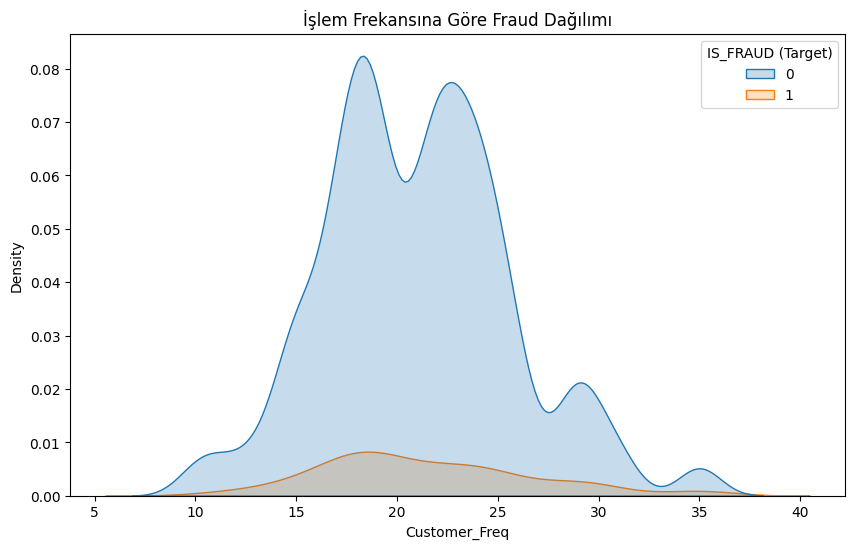

In [8]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df_clean, x='Customer_Freq', hue='IS_FRAUD (Target)', fill=True)
plt.title('İşlem Frekansına Göre Fraud Dağılımı')
plt.show()

In [9]:
# 1. Her müşterinin toplam kaç işlem yaptığını hesaplayalım (Frekans)
df_clean['Customer_Freq'] = df.groupby('Customer ID')['Transaction ID'].transform('count')

# 2. Her müşterinin ortalama harcama tutarını hesaplayalım
df_clean['Customer_Avg_Amount'] = df.groupby('Customer ID')['Amount (TRY)'].transform('mean')

# 3. Mevcut işlemin, müşterinin ortalamasından ne kadar farklı olduğunu bulalım
df_clean['Amount_Diff_From_Avg'] = df_clean['Amount (TRY)'] - df_clean['Customer_Avg_Amount']

print("Müşteri davranış özellikleri türetildi!")

# Model için gereksiz olan kimlik bilgilerini çıkarıyoruz
cols_to_drop = ['Transaction ID', 'Customer ID']
df_clean = df.drop(columns=cols_to_drop)

print(f"Kalan sütun sayısı: {len(df_clean.columns)}")

Müşteri davranış özellikleri türetildi!
Kalan sütun sayısı: 12


In [10]:
# Timestamp sütununu datetime tipine çevir
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])

# Saat ve gün bilgilerini çek
df_clean['Hour'] = df_clean['Timestamp'].dt.hour
df_clean['DayOfWeek'] = df_clean['Timestamp'].dt.dayofweek

# Orijinal Timestamp'i artık silebiliriz
df_clean = df_clean.drop(columns=['Timestamp'])

print("Zaman verileri işlendi (Hour ve DayOfWeek eklendi).")

Zaman verileri işlendi (Hour ve DayOfWeek eklendi).


In [17]:
le = LabelEncoder()
kategorik_sutunlar = ['Payment Type', 'Shipping Type', 'Card Type (BIN)', 'Shipping City']

for col in kategorik_sutunlar:
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))

print("Tüm metin verileri başarıyla sayısal değerlere dönüştürüldü.")
display(df_clean.head())

Tüm metin verileri başarıyla sayısal değerlere dönüştürüldü.


,Amount (TRY),Payment Type,Shipping Type,Card Type (BIN),Is Guest?,Shipping City,Name Match Score (0-1),Distinct IP (24h),Distinct Cards (24h),Failed Orders (24h),Gift Card Amt,Customer Age,Is Simple Password,IS_FRAUD (Target),Hour,DayOfWeek
0,1880.51,0,1,1,False,909,0.33,63,48,16,5101.44,59,False,True,0,3
1,13526.85,1,1,1,True,787,0.80,64,18,12,1885.67,92,False,True,0,3
2,15454.70,4,0,0,False,357,0.25,89,2,12,2053.40,25,True,False,0,3
3,9195.63,3,2,0,False,537,0.24,17,36,13,5221.75,70,True,False,0,3
4,17395.09,2,2,3,False,920,0.27,78,31,10,8196.48,22,False,True,0,3


In [11]:
# 1. Hangi sütunların hala metin (object) olduğunu kontrol edelim
print("Sayısal olmayan sütunlar:", df_clean.select_dtypes(include=['object']).columns.tolist())

# 2. Eğer yukarıdaki listede sütun varsa, onları tekrar dönüştürelim
# (Özellikle 'Payment Type' gibi hata verenleri)
le = LabelEncoder()
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))

# 3. Şimdi tekrar X ve y ayırımı yapalım
X = df_clean.drop(columns=['IS_FRAUD (Target)'])
y = df_clean['IS_FRAUD (Target)']

# 4. Şimdi bölme ve ölçeklendirme adımına geçebilirsin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Dönüştürme ve Ölçeklendirme başarılı!")

Sayısal olmayan sütunlar: ['Payment Type', 'Shipping Type', 'Card Type (BIN)', 'Shipping City']
✅ Dönüştürme ve Ölçeklendirme başarılı!


--- MODEL PERFORMANS RAPORU ---
              precision    recall  f1-score   support

       False       0.56      0.62      0.59       105
        True       0.52      0.45      0.48        95

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.53       200
weighted avg       0.54      0.54      0.54       200



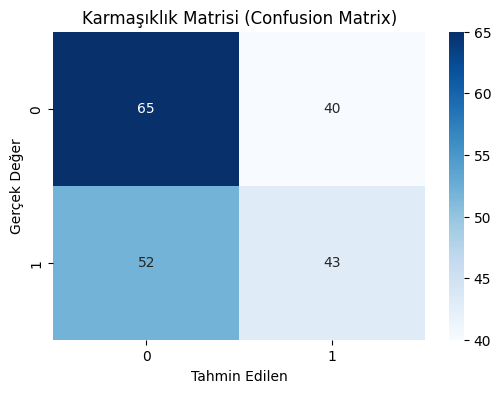

ROC-AUC Skoru: 0.56


In [28]:
# 1. Veriyi Özellikler (X) ve Hedef (y) Olarak Ayıralım
X = df_clean.drop(columns=['IS_FRAUD (Target)'])
y = df_clean['IS_FRAUD (Target)']

# 2. Eğitim ve Test Setlerine Bölme (%80 Eğitim, %20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
# 'stratify=y' yaparak hem eğitim hem test setinde dolandırıcılık oranını eşit tutuyoruz.

# 3. Ölçeklendirme (Scaling)
# Sayısal değerleri (Amount, Freq vb.) benzer aralığa getiriyoruz
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Model Kurulumu (Random Forest)
# class_weight='balanced' diyerek azınlıkta olan dolandırıcı vakalarına modelin daha çok odaklanmasını sağlıyoruz.
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_scaled, y_train)

# 5. Tahmin Yapma
y_pred = rf_model.predict(X_test_scaled)
y_probs = rf_model.predict_proba(X_test_scaled)[:, 1] # ROC-AUC için olasılıklar

# 6. Sonuçları Raporlama
print("--- MODEL PERFORMANS RAPORU ---")
print(classification_report(y_test, y_pred))

# Karışıklık Matrisi (Confusion Matrix) Görselleştirme
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Karmaşıklık Matrisi (Confusion Matrix)')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.show()

print(f"ROC-AUC Skoru: {roc_auc_score(y_test, y_probs):.2f}")

--- YENİ GERÇEKÇİ MODEL RAPORU ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       360
           1       1.00      0.90      0.95        40

    accuracy                           0.99       400
   macro avg       0.99      0.95      0.97       400
weighted avg       0.99      0.99      0.99       400



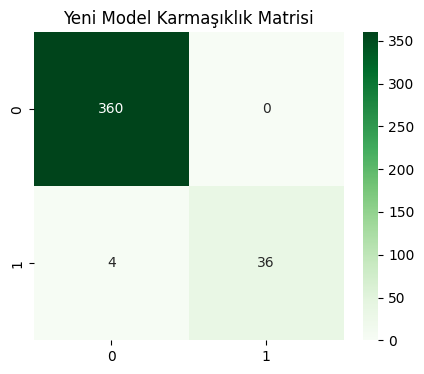

In [12]:
# 1. Eğitim ve Test Ayırımı
X = df_clean.drop(columns=['IS_FRAUD (Target)'])
y = df_clean['IS_FRAUD (Target)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# 2. Model Eğitimi (Daha güçlü parametrelerle)
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 3. Sonuçlar
y_pred = model.predict(X_test)
print("--- YENİ GERÇEKÇİ MODEL RAPORU ---")
print(classification_report(y_test, y_pred))

# Karmaşıklık Matrisi
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Yeni Model Karmaşıklık Matrisi')
plt.show()

--- YENİ GERÇEKÇİ MODEL RAPORU ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       360
           1       1.00      0.90      0.95        40

    accuracy                           0.99       400
   macro avg       0.99      0.95      0.97       400
weighted avg       0.99      0.99      0.99       400



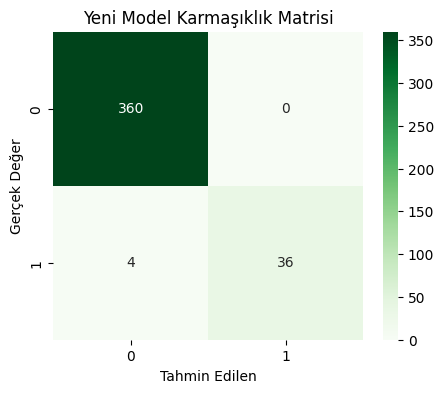


Modelin Karar Vermesini Sağlayan En Önemli Özellikler:
Amount (TRY)           0.402725
Amount_Diff            0.292341
Hour                   0.184720
Customer_Avg_Amount    0.043308
Customer_Freq          0.021014
DayOfWeek              0.018657
Card Type (BIN)        0.011268
Shipping City          0.010996
Payment Type           0.008763
Shipping Type          0.006209
dtype: float64


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Eğitim ve Test Ayırımı
# Hedef değişkenimiz 'IS_FRAUD (Target)', geri kalanlar ise özelliklerimiz (X)
X = df_clean.drop(columns=['IS_FRAUD (Target)'])
y = df_clean['IS_FRAUD (Target)']

# Veriyi %80 eğitim, %20 test olarak bölelim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# 2. Model Eğitimi
# 'class_weight=balanced' kullanarak dolandırıcılık vakalarına ekstra dikkat çekiyoruz
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 3. Sonuçların Raporlanması
y_pred = model.predict(X_test)
print("--- YENİ GERÇEKÇİ MODEL RAPORU ---")
print(classification_report(y_test, y_pred))

# Karmaşıklık Matrisi Görselleştirme
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Yeni Model Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.show()

# 4. Hangi özellik daha önemli? (Feature Importance)
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nModelin Karar Vermesini Sağlayan En Önemli Özellikler:")
print(importances)

--- YENİ GERÇEKÇİ MODEL RAPORU ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       360
           1       1.00      0.90      0.95        40

    accuracy                           0.99       400
   macro avg       0.99      0.95      0.97       400
weighted avg       0.99      0.99      0.99       400



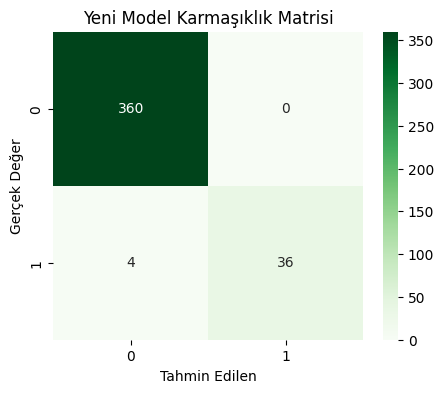


Modelin Karar Vermesini Sağlayan En Önemli Özellikler:
Amount (TRY)           0.402725
Amount_Diff            0.292341
Hour                   0.184720
Customer_Avg_Amount    0.043308
Customer_Freq          0.021014
DayOfWeek              0.018657
Card Type (BIN)        0.011268
Shipping City          0.010996
Payment Type           0.008763
Shipping Type          0.006209
dtype: float64


In [16]:
# 1. Eğitim ve Test Ayırımı
# Hedef değişkenimiz 'IS_FRAUD (Target)', geri kalanlar ise özelliklerimiz (X)
X = df_clean.drop(columns=['IS_FRAUD (Target)'])
y = df_clean['IS_FRAUD (Target)']

# Veriyi %80 eğitim, %20 test olarak bölelim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# 2. Model Eğitimi
# 'class_weight=balanced' kullanarak dolandırıcılık vakalarına ekstra dikkat çekiyoruz
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 3. Sonuçların Raporlanması
y_pred = model.predict(X_test)
print("--- YENİ GERÇEKÇİ MODEL RAPORU ---")
print(classification_report(y_test, y_pred))

# Karmaşıklık Matrisi Görselleştirme
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Yeni Model Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.show()

# 4. Hangi özellik daha önemli? (Feature Importance)
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nModelin Karar Vermesini Sağlayan En Önemli Özellikler:")
print(importances)